In [56]:
# -------------------------------------------------------------------------------------
# Libraries
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import geopandas as gdp
import datetime
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
from zipfile import ZipFile
import rioxarray
from os.path import basename

# Functions
# Zip the files from given directory that matches the filter
def zipFilesInDir(dirName, zipFileName, fileStart):
   # create a ZipFile object
   with ZipFile(zipFileName, 'w') as zipObj:
       # Iterate over all the files in directory
       for folderName, subfolders, filenames in os.walk(dirName):
            for filename in filenames:
                if filename.startswith(fileStart):
                    # create complete filepath of file in directory
                    filePath = os.path.join(folderName, filename)
                    # Add file to zip
                    zipObj.write(filePath, basename(filePath))

In [61]:
# -------------------------------------------------------------------------------------
# Shapefile, Inputs
sCsvNameIn = 'input/SequiaMDRyT_2002_2019.csv' 

sTimeAgg = 'M' # Y = yearly; M = monthly
sSpaceAgg = 'Mu' # D = Departments; Mu = Municipalities; MR = MacroRegions
sTypeImpact = 'A' # A = crop (cultivo); C = cattle (ganado)

sDepNameIn = 'input/shp/BOL_departamentos.shp'
sMunNameIn = 'input/shp/BOL_municipios.shp'
sMRegNameIn = 'input/shp/BOL_macroregiones.shp'
sFldOut = 'output'

In [62]:
# -------------------------------------------------------------------------------------
# Import VIDECI Impact dataset (csv format, revision)
df = pd.read_csv(sCsvNameIn,delimiter=",", encoding='utf-8')

# Import Departments Shapefile
gfd = gdp.read_file(sDepNameIn)

# Import Municipalities Shapefile
gfm = gdp.read_file(sMunNameIn)

# Import MacroRegion Shapefile
gfr = gdp.read_file(sMRegNameIn)

# Convert dates to datetime
df['event_date'] = pd.to_datetime(df['event_date'], format="%d/%m/%Y")
# Set time index
df = df.set_index(["event_date"])

# Impact type
if sTypeImpact == 'A':
    colImpact = 'Hec_agr'
elif sTypeImpact == 'C':
    colImpact = 'N_cattle'

# Get people affected / impact per year/month - total
df_m_tot = df[colImpact].resample(sTimeAgg, convention='end').sum()
dfm = df_m_tot.to_frame()
dDates = dfm.index.values
final_col_names = ['Total_BO']

if sSpaceAgg == 'D':  
    # Get people affected / impact per year for each department
    for depart in df.Dep.unique():
        
        df_sel = df[df['Dep']==depart]
        df_m = df_sel[colImpact].resample(sTimeAgg, convention='end').sum()
        dfm = pd.concat([dfm, df_m], axis=1, sort=False)
        final_col_names.append(depart)
        del df_m     
        
elif sSpaceAgg == 'Mu':
    # Get people affected / impact per year for each municipality # With code..safer
    for muncode in df.cod_mun.unique():
        
        df_sel = df[df['cod_mun']==muncode]
        df_m = df_sel[colImpact].resample(sTimeAgg, convention='end').sum()
        dfm = pd.concat([dfm, df_m], axis=1, sort=False)
        final_col_names.append(muncode)
        del df_m
        
elif sSpaceAgg == 'MR':
    # Get people affected / impact per year for each macroregion
    for macroreg in df.MacroReg.unique():
        
        df_sel = df[df['MacroReg']==macroreg]
        df_m = df_sel[colImpact].resample(sTimeAgg, convention='end').sum()
        dfm = pd.concat([dfm, df_m], axis=1, sort=False)
        final_col_names.append(macroreg)
        del df_m   
else:
    print('Chose correct Space Aggregation: Y or Mu')
    
dfm.columns = final_col_names

if sTimeAgg == 'Y':
    dfm['Year']=pd.to_datetime(dfm.index.values).year
    dfm = dfm.set_index(['Year'])
elif sTimeAgg == 'M':
    dfm['Yr-Month']=pd.to_datetime(dfm.index.values).to_period('M').strftime('%b-%Y')
    dfm = dfm.set_index(['Yr-Month']) 
else:
    print('Chose correct Time Aggregation: Y or M')
    
# Convert to Shapefile
# transpose dataframe and remove first line (TOTAL_BO)
dfmt = dfm.transpose()
dfmts = dfmt.drop('Total_BO')
dfmtsbkp = dfmts
dfmtsbkp = dfmtsbkp.fillna(0)

dfmts['SUM'] = np.nan
dfmts['MEAN'] = np.nan
dfmts = dfmts.fillna(0)
#dfmts = dfmts.astype(int)
if sSpaceAgg == 'D':
    for depart in df.Dep.unique():
        dfmts.loc[depart,'SUM'] = np.sum(dfmtsbkp.loc[depart])
        dfmts.loc[depart,'MEAN'] = np.mean(dfmtsbkp.loc[depart])
        
    dfmts['Dep'] = dfmts.index
    dfmts.columns = dfmts.columns.map(str)
    gfs_merge = gfd.merge(dfmts, on='Dep')
elif sSpaceAgg == 'Mu':
    dfmts.columns = dfmts.columns.map(str)
    dfmts['COD1_SECC'] = dfmts.index
    dfmts.COD1_SECC = dfmts.COD1_SECC.astype(float)
    gfm.COD1_SECC = gfm.COD1_SECC.astype(float)
    gfs_merge = gfm.merge(dfmts, on='COD1_SECC')
elif sSpaceAgg == 'MR':
    # Get people affected per year for each macroregion
    for macroreg in df.MacroReg.unique():
        dfmts.loc[macroreg,'SUM'] = np.sum(dfmtsbkp.loc[macroreg])
        dfmts.loc[macroreg,'MEAN'] = np.mean(dfmtsbkp.loc[macroreg])
        
    dfmts['MacroReg'] = dfmts.index
    dfmts.columns = dfmts.columns.map(str)
    gfs_merge = gfr.merge(dfmts, on='MacroReg')
        
else:
    print('Chose correct Space Aggregation: D or Mu')

# Save as Shapefile
if not os.path.exists(os.path.join(sFldOut,'shp')):
    os.makedirs(os.path.join(sFldOut,'shp'))    
sShpNameOutBase = 'MDRyT_impacts_' + sTimeAgg + '_' + sSpaceAgg + '_' + sTypeImpact
sShpNameOut = sShpNameOutBase + '.shp'
sSaveName = os.path.join(sFldOut,'shp',sShpNameOut)
gfs_merge.to_file(sSaveName)

# Save as ZIP
if not os.path.exists(os.path.join(sFldOut,'zip')):
    os.makedirs(os.path.join(sFldOut,'zip'))
sSaveNameZip = os.path.join(sFldOut,'zip',sShpNameOutBase + '.zip')
zipFilesInDir(os.path.join(sFldOut,'shp'), sSaveNameZip, sShpNameOutBase)

In [63]:
# -------------------------------------------------------------------------------------
## Plot, Inputs
datePlot = '2016-01' # YYYY-MM with YYYY=2016
sTimeAgg = 'M' # Y = yearly; M = monthly
sSpaceAgg = 'Mu' # D = Departments; Mu = Municipalities; MR = MacroRegions
sTypeImpact = 'A' # A = crop (cultivo); C = cattle (ganado)

## Combined Index
sPathIndex = 'productos/Combined'# Folder
# METEO
INDEX_METEO="SPI" #SPI or SPEI
accumulation_METEO = "06" # SPI/SPEI=03,06
# IDRO
INDEX_HUM="SWDI" #SWDI or SSMI
accumulation_HUM = "02" #SWDI/SSMI=02,03
# VEG 1
INDEX_VEG1="VHI" #VHI
accumulation_VEG1 = "01" #VHI=01,02
# VEG 2
INDEX_VEG2="FAPAR" #FAPAR
accumulation_VEG2 = "01" #FAPAR=01


****************************************+*********
------------------->2016-01


,NOM_DEP,NOM_PROV,NOM_MUN,POBLACION,Hec_agr
27,Cochabamba,Arque,Arque,10597.0,65
51,Oruro,Sabaya,Coipasa,903.0,3108
81,Oruro,Sur Carangas,Santiago de Andamarca,5216.0,218
102,Oruro,Sabaya,Chipaya,2003.0,115
112,Oruro,Litoral,Esmeralda,2702.0,392
119,Oruro,Ladislao Cabrera,Pampa Aullagas,2973.0,363
152,Oruro,San Pedro De Totora,San Pedro de Totora,5531.0,89
209,Chuquisaca,Sud Cinti,Culpina,17731.0,4130


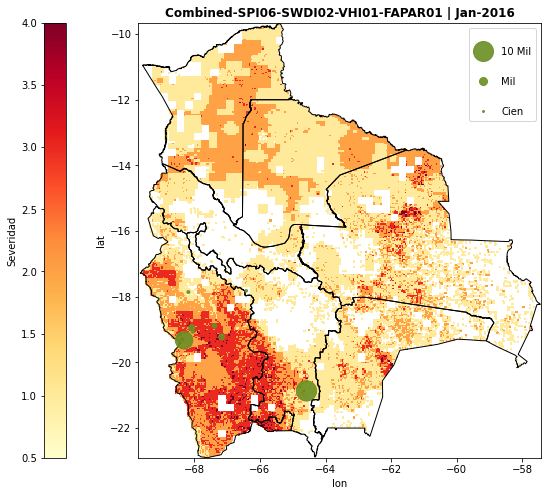

In [64]:
oDate = datetime.datetime.strptime(str(datePlot),'%Y-%m')
print('****************************************+*********')    
print('------------------->' + oDate.strftime('%Y-%m'))
    
yy = oDate.strftime('%Y')
mm = oDate.strftime('%m')
dateAn = oDate.strftime('%b-%Y')

# Load Impacts Shapefile
sImpactShp = 'MDRyT_impacts_' + sTimeAgg + '_' + sSpaceAgg + '_' + sTypeImpact + '.shp'
shpPath = os.path.join(sFldOut,'shp',sImpactShp)
gdf = gdp.read_file(shpPath)

# Import Borders
gdf_bound = gdp.read_file(sMRegNameIn)

# Plot Configuration
cmap = plt.get_cmap('YlOrRd')
cmap.set_under('k', alpha=0)
# Impact type
if sTypeImpact == 'A':
    colImpact = 'Hec_agr'
    divImp = 10
    blue_circ_big_no = mlines.Line2D([], [], color='olivedrab', marker='o', markersize=1, alpha = 0.0, label='', linewidth=0)
    blue_circ_big = mlines.Line2D([], [], color='olivedrab', marker='o', markersize=20, alpha = 0.9, label='10 Mil', linewidth=0)
    blue_circ_med_no = mlines.Line2D([], [], color='olivedrab', marker='o', markersize=1, alpha = 0.0, label='', linewidth=0)
    blue_circ_med = mlines.Line2D([], [], color='olivedrab', marker='o', markersize=8, alpha = 0.9, label='Mil', linewidth=0)
    blue_circ_sma_no = mlines.Line2D([], [], color='olivedrab', marker='o', markersize=1, alpha = 0.0, label='', linewidth=0)
    blue_circ_sma = mlines.Line2D([], [], color='olivedrab', marker='o', markersize=2, alpha = 0.9, label='Cien', linewidth=0)
elif sTypeImpact == 'C':
    colImpact = 'N_cattle'
    divImp = 1
    # Set legend
    blue_circ_big_no = mlines.Line2D([], [], color='olivedrab', marker='o', markersize=1, alpha = 0.0, label='', linewidth=0)
    blue_circ_big = mlines.Line2D([], [], color='olivedrab', marker='o', markersize=20, alpha = 0.9, label='500', linewidth=0)
    blue_circ_med_no = mlines.Line2D([], [], color='olivedrab', marker='o', markersize=1, alpha = 0.0, label='', linewidth=0)
    blue_circ_med = mlines.Line2D([], [], color='olivedrab', marker='o', markersize=8, alpha = 0.9, label='100', linewidth=0)
    blue_circ_sma_no = mlines.Line2D([], [], color='olivedrab', marker='o', markersize=1, alpha = 0.0, label='', linewidth=0)
    blue_circ_sma = mlines.Line2D([], [], color='olivedrab', marker='o', markersize=2, alpha = 0.9, label='10', linewidth=0)

# Select Impact column (date)
if dateAn in gdf.columns:
    gdf_sel = gdf[gdf[dateAn].astype(int)>0]
    gdf_sel[colImpact] = gdf_sel[dateAn].astype(int)
    
    # Import raster
    sNameIndex = 'Combined-' + INDEX_METEO + accumulation_METEO + '-' + INDEX_HUM + accumulation_HUM + '-' + INDEX_VEG1 + accumulation_VEG1 + '-' + INDEX_VEG2 + accumulation_VEG2            
    tifName = sNameIndex + '_' + yy + mm + '.tif'
    tifPath = os.path.join(sPathIndex,yy,mm,tifName)
    if os.path.exists(tifPath):
        src = rioxarray.open_rasterio(tifPath)
        title = sNameIndex + ' | ' + dateAn
    else:
        print(tifName + ' not found')
        title = dateAn
    
    # PLOT   
    fig, ax = plt.subplots(figsize=(13, 8))
    if os.path.exists(tifPath):
        img = src.plot(cmap=cmap, vmin=0.5, vmax=4, ax=ax,add_colorbar=False)
    
    plt.title(title,fontweight="bold") 
    plt.xlabel('lon')
    plt.ylabel('lat')
    if os.path.exists(tifPath):
        plt.colorbar(img,ax=[ax],location='left', label='Severidad')
    
    gdf_bound.plot(ax=ax, facecolor='none', edgecolor='black')
    #gdf_sel.plot(ax=ax, facecolor='none', edgecolor='blue')
    if gdf_sel.empty is True:
        print("no impacts reported on: " + dateAn)
    else:        
        gdf_sel.centroid.plot(ax=ax, markersize=gdf_sel[colImpact]/divImp, alpha = 0.9, facecolor='olivedrab')
        plt.legend(handles=[blue_circ_big_no,blue_circ_big,blue_circ_med_no,blue_circ_med,blue_circ_sma_no,blue_circ_sma])       
    
else:
    print('no impact column for: ' + dateAn)

gdf_sel = gdf_sel[['NOM_DEP', 'NOM_PROV', 'NOM_MUN', 'POBLACION', colImpact]]
display(gdf_sel)
# Save Csv
if not os.path.exists(os.path.join(sFldOut,'csv')):
    os.makedirs(os.path.join(sFldOut,'csv'))
sNameCsv = dateAn + '_MDRyT_impacts_' + sTimeAgg + '_' + sSpaceAgg + '_' + sTypeImpact + '.csv'
sFileOutCsv = os.path.join(sFldOut,'csv',sNameCsv)
gdf_sel.to_csv(sFileOutCsv)
